In [1]:
import numpy as np
import cv2, random, sys, os, glob
from itertools import chain

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
from shutil import copyfile
copyfile(src = "../input/facedataset/FUNC_script.py", dst = "../working/FUNC_script.py")
from FUNC_script import *

In [3]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

### CONFIG

In [4]:
%%capture

totalSubjects= 5
mask= load_img('../input/facedataset/binary_glass_mask2.jpg')/255
imgDir= '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/'
# Load FaceNet Model
model = load_model('../input/face-net-keras-model/facenet_keras.h5', compile= False)
model.trainable= False

# (index(0)==legitimate)
# (index((totalSubjects-1))== Adversarial)
subjects= ['s01', 's33', 's27', 's06', 's20'] #['s33', 's12', 's27', 's06', 's26']
subjectLabels=[]
subjectsDict= {k:[] for k in subjects}
target= subjects[0]

2022-01-18 15:25:45.778338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:25:45.994754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:25:45.995889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:25:45.997762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
totSample=0
for sam in subjects:
    for path in glob.glob(imgDir+sam+'/*'):
        img= load_img(path, resize=160)
        img= model.predict(img[np.newaxis, :, :, :]/255.0)[0]
        subjectsDict[sam].append(img)
        subjectLabels.append(subjects.index(sam))
        totSample+=1
totSample

2022-01-18 15:25:54.120615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-18 15:25:57.119490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50

In [6]:
flattened = np.array([val for sublist in list(subjectsDict.values()) for val in sublist])

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)

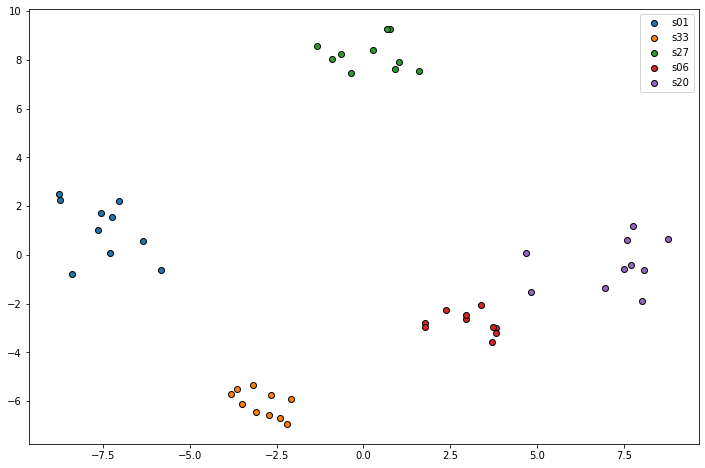

In [7]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [8]:
flattened.shape, len(subjectLabels)

((50, 128), 50)

In [9]:
totalSubjects

5

In [10]:
from sklearn.cluster import KMeans
class kMeansModel:
    def __init__(self, n_class):
        self.n_class=n_class
        self.model= KMeans(n_clusters=self.n_class, random_state=0)
    def fit(self, data):
        self.model.fit(data)
        self.centers= self.model.cluster_centers_
        return self.model.labels_
    def predict(self, data, th=15):
        res=[]
        for d in data:
            arr= np.linalg.norm(self.centers-d, axis=1)
            #print(arr)
            if arr.min()<=th:
                ind= np.where(arr==arr.min())[0][0]
                res.append(ind)
            else:
                res.append(-1)
        return np.array(res)        

In [11]:
KMEANS= kMeansModel(totalSubjects)
KMEANS.fit(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

### Adversarial Centroid

In [12]:
# Data  Loading
def load_data(path):
    X=[]
    for i, sample in enumerate(path):
        image= load_img(sample)
        image = cv2.resize(image, (160, 160))
        X.append(image/255.0)
    return np.array(X)

# Loss
def loss_object(pred, label, delta):
    # Loss= euclidean distance + Delta_x pixel Variance
    dist= Euclidean_dist(pred, label)
#     print(dist)
#     print(tf.norm(label - pred, axis=-1))
    variance= Sample_variance(delta)
    Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
    return Loss

def back_propagate(model, X, mask, delta_x, Xc):
    with tf.GradientTape() as g:
        g.watch(delta_x)
        X_batch= Generate_sample(X, delta_x, mask)
        feature= model(X_batch)
        loss= loss_object(pred= feature, label= Xc, delta= delta_x)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = g.gradient(loss, delta_x)
    return gradient, tf.reduce_mean(loss).numpy()

In [13]:
# tragetImages= load_data(glob.glob(imgDir+target+'/*'))
# tragetFeature= model.predict(tragetImages)

advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
advFeature= model.predict(advImages)
Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
advRefFeature= Generate_target(advFeature[3], batch_size=advImages.shape[0])
advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 160, 160, 3), (10, 128), (10, 128))

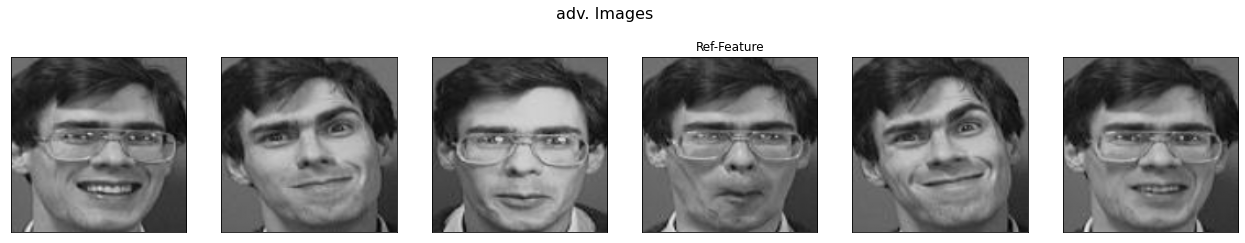

In [14]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [15]:
Delta.shape

(10, 160, 160, 3)

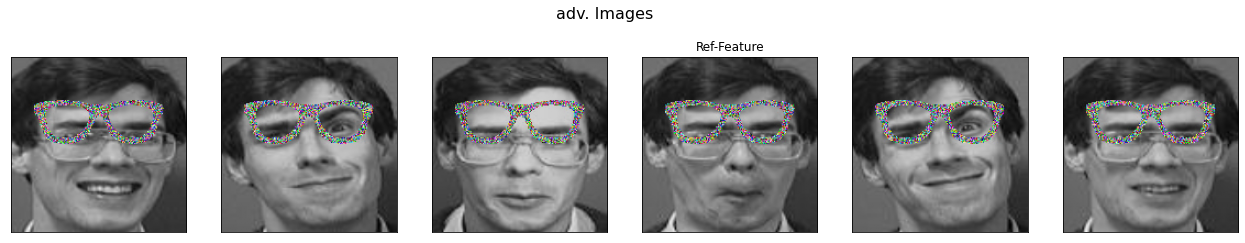

In [16]:
advImagesShow= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [17]:
# Tf Variables
advImages= tf.Variable(advImages, dtype=tf.float64)
Delta= tf.Variable(Delta, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
advRefFeature= tf.Variable(advRefFeature)

In [18]:
epoch= 400
Lambda= 0.2
for ep  in range(epoch+1):
    grad, loss= back_propagate(model, advImages, mask, Delta, advRefFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%10 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 170.327
Epoch: 10   Loss: 157.645
Epoch: 20   Loss: 147.184
Epoch: 30   Loss: 137.225
Epoch: 40   Loss: 127.600
Epoch: 50   Loss: 118.255
Epoch: 60   Loss: 109.202
Epoch: 70   Loss: 100.420
Epoch: 80   Loss: 91.921
Epoch: 90   Loss: 83.729
Epoch: 100   Loss: 75.885
Epoch: 110   Loss: 68.425
Epoch: 120   Loss: 61.341
Epoch: 130   Loss: 54.704
Epoch: 140   Loss: 48.515
Epoch: 150   Loss: 42.833
Epoch: 160   Loss: 37.687
Epoch: 170   Loss: 33.125
Epoch: 180   Loss: 29.118
Epoch: 190   Loss: 25.707
Epoch: 200   Loss: 22.810
Epoch: 210   Loss: 20.436
Epoch: 220   Loss: 18.489
Epoch: 230   Loss: 16.853
Epoch: 240   Loss: 15.548
Epoch: 250   Loss: 14.462
Epoch: 260   Loss: 13.581
Epoch: 270   Loss: 12.823
Epoch: 280   Loss: 12.250
Epoch: 290   Loss: 11.702
Epoch: 300   Loss: 11.289
Epoch: 310   Loss: 10.934
Epoch: 320   Loss: 10.665
Epoch: 330   Loss: 10.415
Epoch: 340   Loss: 10.196
Epoch: 350   Loss: 10.052
Epoch: 360   Loss: 9.883
Epoch: 370   Loss: 9.779
Epoch: 380   Loss

In [19]:
subjects.append('deltaAdvCentroid')
subjectsDict['deltaAdvCentroid']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaAdvCentroid'].shape

(10, 128)

In [20]:
flattened= np.vstack((flattened, subjectsDict['deltaAdvCentroid']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(60, 2)

In [21]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

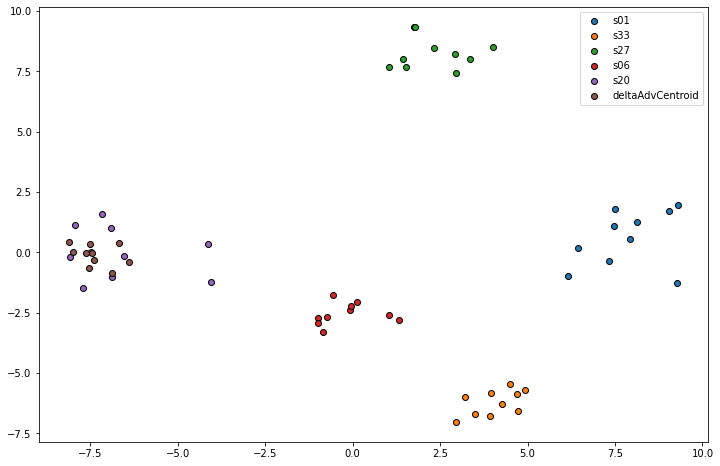

In [22]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+1):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

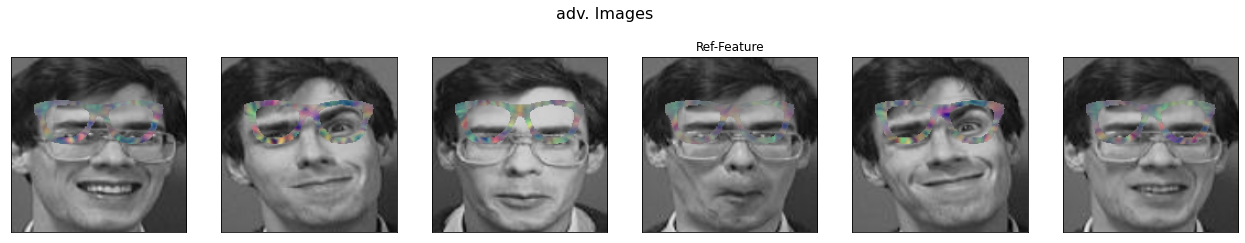

In [23]:
advImagesShow0= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

### Target Att....


In [24]:
tragetImages= load_data(glob.glob(imgDir+target+'/*'))
tragetFeature= model.predict(tragetImages)
targetRefFeature= Generate_target(tragetFeature[3], batch_size=tragetImages.shape[0])
tragetImages.shape, tragetFeature.shape

# advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
# advFeature= model.predict(advImages)
# Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
# advRefFeature= Generate_target(advFeature[5], batch_size=advImages.shape[0])
# advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 128))

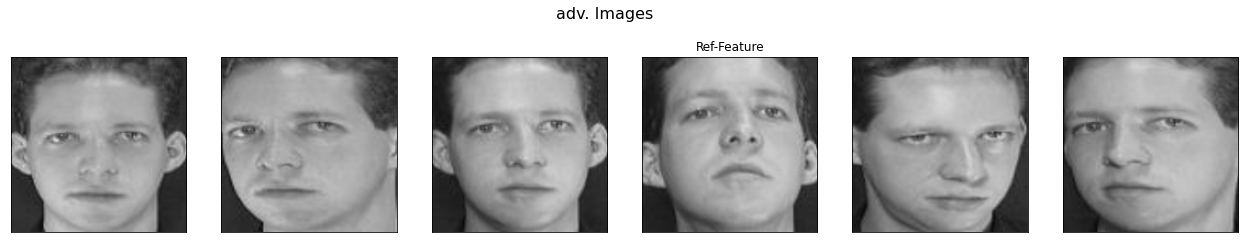

In [25]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(tragetImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [26]:
epoch= int(400 *4.5)
Lambda= 0.014
for ep  in range(epoch):
    grad, loss= back_propagate(model, advImages, mask, Delta, tragetFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%20 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 21.050
Epoch: 20   Loss: 20.311
Epoch: 40   Loss: 19.709
Epoch: 60   Loss: 19.222
Epoch: 80   Loss: 18.819
Epoch: 100   Loss: 18.442
Epoch: 120   Loss: 18.112
Epoch: 140   Loss: 17.869
Epoch: 160   Loss: 17.661
Epoch: 180   Loss: 17.472
Epoch: 200   Loss: 17.290
Epoch: 220   Loss: 17.115
Epoch: 240   Loss: 16.952
Epoch: 260   Loss: 16.833
Epoch: 280   Loss: 16.729
Epoch: 300   Loss: 16.636
Epoch: 320   Loss: 16.550
Epoch: 340   Loss: 16.473
Epoch: 360   Loss: 16.398
Epoch: 380   Loss: 16.329
Epoch: 400   Loss: 16.266
Epoch: 420   Loss: 16.208
Epoch: 440   Loss: 16.152
Epoch: 460   Loss: 16.097
Epoch: 480   Loss: 16.045
Epoch: 500   Loss: 15.996
Epoch: 520   Loss: 15.949
Epoch: 540   Loss: 15.904
Epoch: 560   Loss: 15.860
Epoch: 580   Loss: 15.819
Epoch: 600   Loss: 15.780
Epoch: 620   Loss: 15.743
Epoch: 640   Loss: 15.708
Epoch: 660   Loss: 15.673
Epoch: 680   Loss: 15.638
Epoch: 700   Loss: 15.606
Epoch: 720   Loss: 15.575
Epoch: 740   Loss: 15.546
Epoch: 760   Loss:

In [27]:
subjects.append('deltaTarget')
subjectsDict['deltaTarget']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaTarget'].shape

(10, 128)

In [28]:
flattened= np.vstack((flattened, subjectsDict['deltaTarget']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(70, 2)

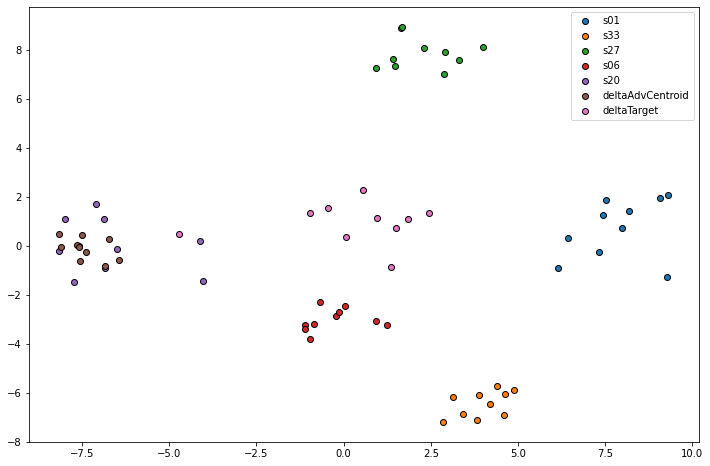

In [29]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+2):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [30]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 4,
       0, 4, 4, 0])

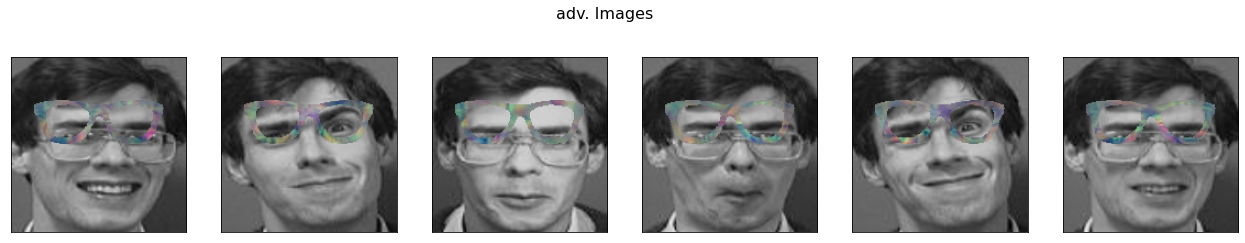

In [31]:
advImagesShow1= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow1[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()

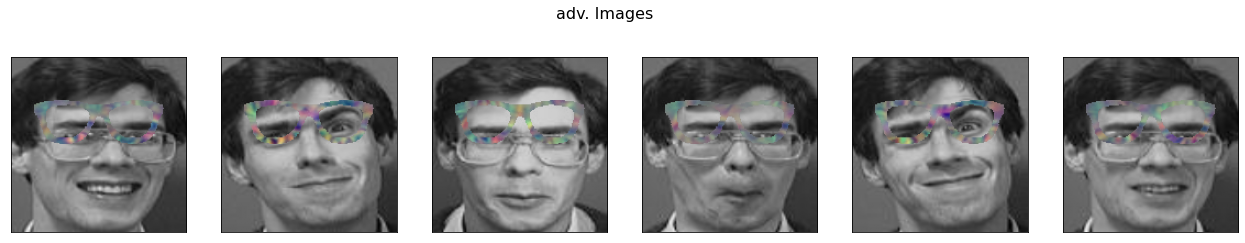

In [32]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()